In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

# Import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

# Import custom classes
from Environment.env_v8 import *
from Functions.visualization_functions import *

# Import custom functions
from Functions.deep_q_learning import *

In [2]:
# Configuration of the network
with open('./Config/network_config_v1.json') as file:
    network_config = file.read()

EP_LENGTH = 100 # Length of the episode

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 30}
Node C: {'type': 'manufacturer', 'I': 30}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


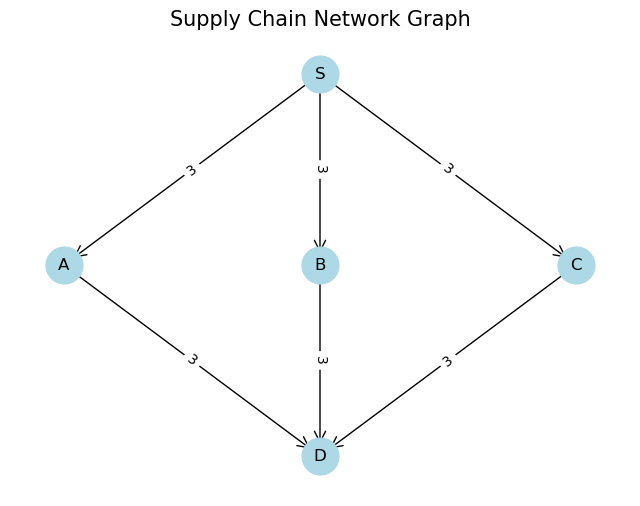

In [3]:
env = SS_Mngmt_Env(
    network_config=network_config,
    EP_LENGTH=EP_LENGTH,
    render_mode="human",
    model_type="heuristic",
    stockout_cost=500,
    order_cost=2,
    item_cost=0.05,
    stock_cost=0.01,
    item_prize=20,
    stock_out_max=1000,
    order_quantities=[0, 10, 20],
    demand_mean=8,
    demand_std=2,
    demand_noise=0,
    demand_noise_std=2,
)
check_env(env, warn=True)

env.render_network()

In [4]:
def compute_safety_stock(env, service_level=0.95):
    lead_time = {}
    for node in env.graph.nodes:
        if node not in ["S", "D"]:
            in_edges = list(env.graph.in_edges(node, data=True))
            if in_edges:
                lead_time[node] = in_edges[0][2]["L"]

    safety_stock = {}
    for node in env.graph.nodes:
        if node not in ["S", "D"]:
            z_score = norm.ppf(service_level)
            node_lead_time = lead_time.get(node, 0)
            safety_stock[node] = env.demand_mean + z_score * env.demand_std * np.sqrt(node_lead_time)

    return safety_stock

compute_safety_stock(env, service_level=0.95)

{'A': 13.697940105787787, 'B': 13.697940105787787, 'C': 13.697940105787787}

In [5]:
# Main simulation loop
episodes = 1
service_level = 0.95

# Compute safety stock for each node
safety_stock = compute_safety_stock(env, service_level)

for episode in range(1, episodes + 1):
    state = env.reset()[0]
    done = False
    score = 0 

    while not done:
        # Get current stock levels
        stock = state["inventory_levels"]
        action = [0] * len(stock)  # Initialize actions

        for i, node in enumerate(env.graph.nodes):
            if node not in ["S", "D"]:  # Ignore source and destination nodes
                # Determine safety stock level for the node
                node_safety_stock = safety_stock.get(node, 0)

                # Policy to avoid stockouts based on safety stock
                if stock[i] > node_safety_stock:
                    action[i] = 0  # No action, stock is above safety level
                elif stock[i] <= node_safety_stock:
                    action[i] = 2  # Order more stock to replenish above safety level

        # Take action and update environment
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # Optionally render the environment
        env.render()

        # Update state
        state = n_state

    print(f"Episode {episode} Score: {score}")

**************************************************

Episode Information
Episode Length: 1
Stock Level (Previous Timestep): [30.0, 30.0, 30.0]
Stock Level: [40. 28. 40.]
Planned Demand: [ 0. 11.  0.]
Actual Demand: [ 0. 12.  0.]
Action: [0, 0, 0]
Deliveries: [10 10 10]
Step Reward: 238.92
Total Reward: 238.92

Backlog:
[False, False, False]

Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}


Stockout Counter:  0
**************************************************

Episode Information
Episode Length: 2
Stock Level (Previous Timestep): [40.0, 28.0, 40.0]
Stock Level: [40. 28. 40.]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [0, 0, 0]
Deliveries: [0 0 0]
Step Reward: -1.08
Total Reward: 237.83999999999997

Backlog:
[False, False, False]

Order Queue:
{   'A': deque([0, 0, 0], maxlen=3),
    'B': deque([0, 0, 0], maxlen=3),
    'C': deque([0, 0, 0], maxlen=3)}


Stockout Counter:  0
******************

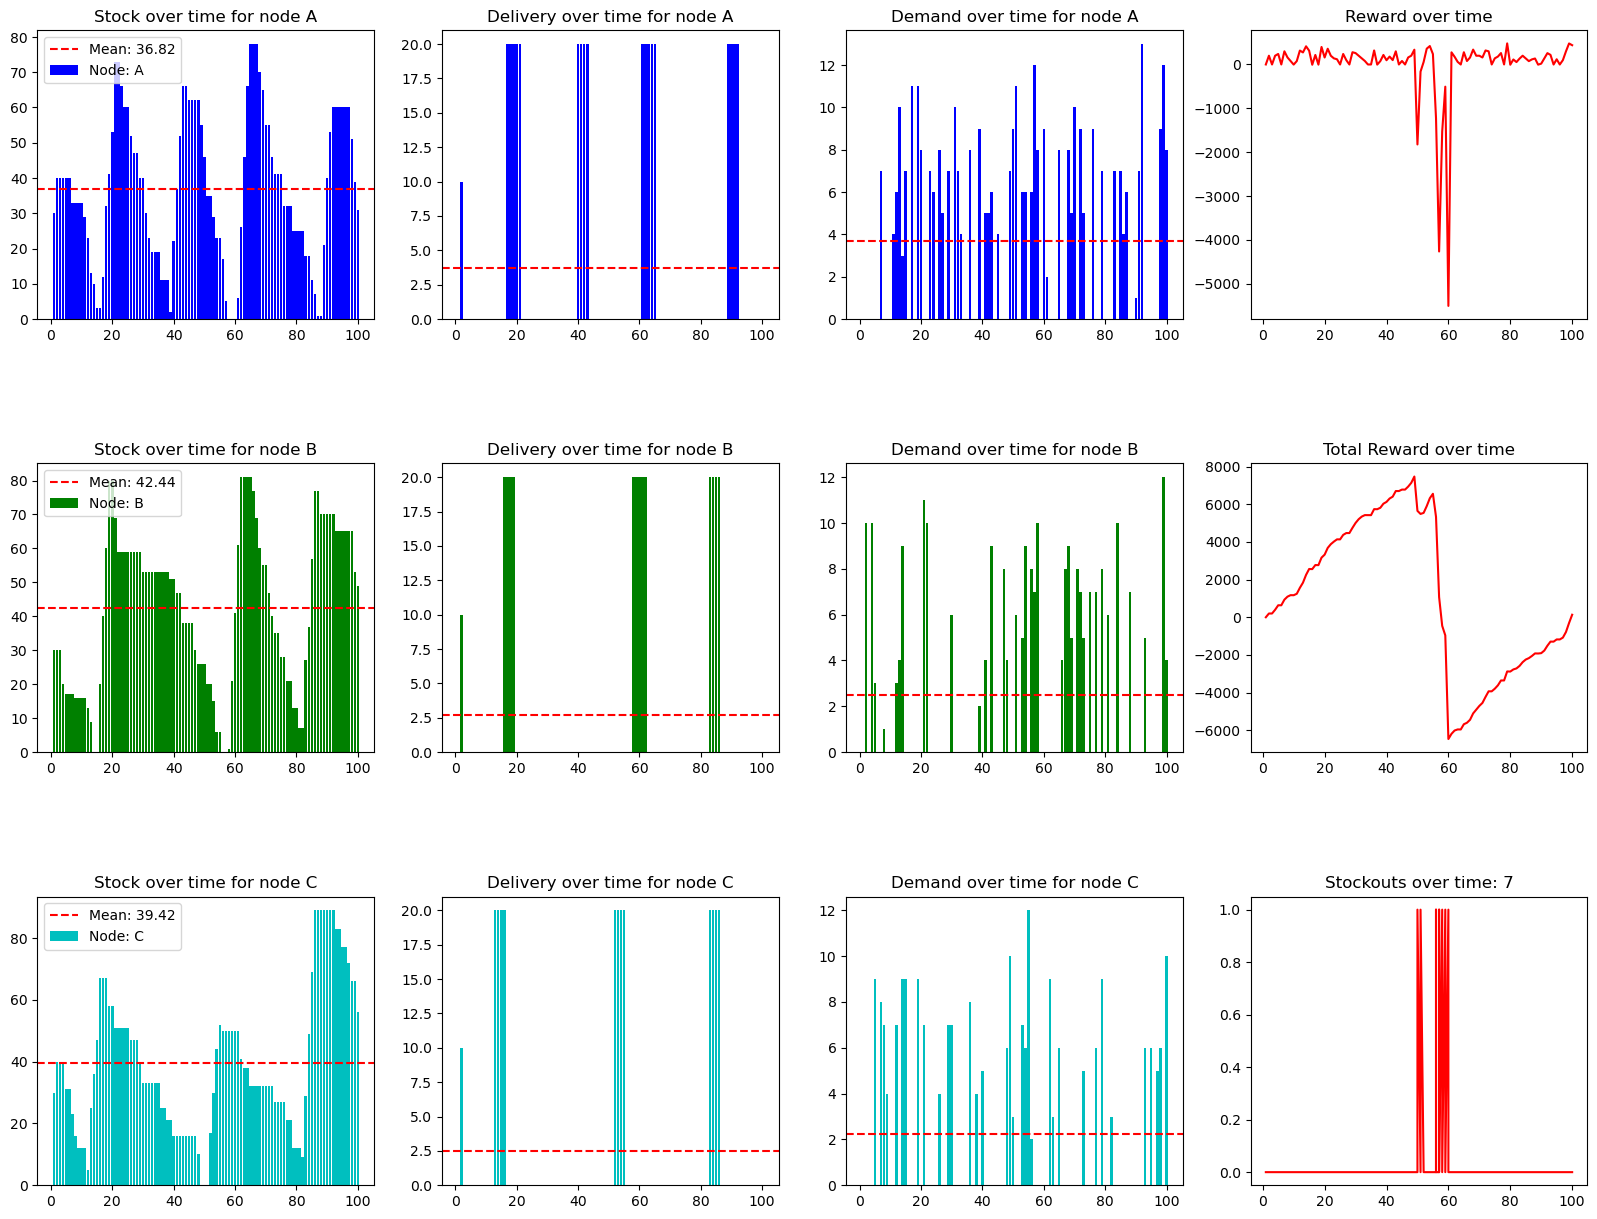

In [6]:
df = pd.read_csv('./Data/2024-11-30_19_last_environment_data_heuristic.csv')
plot_data(df)

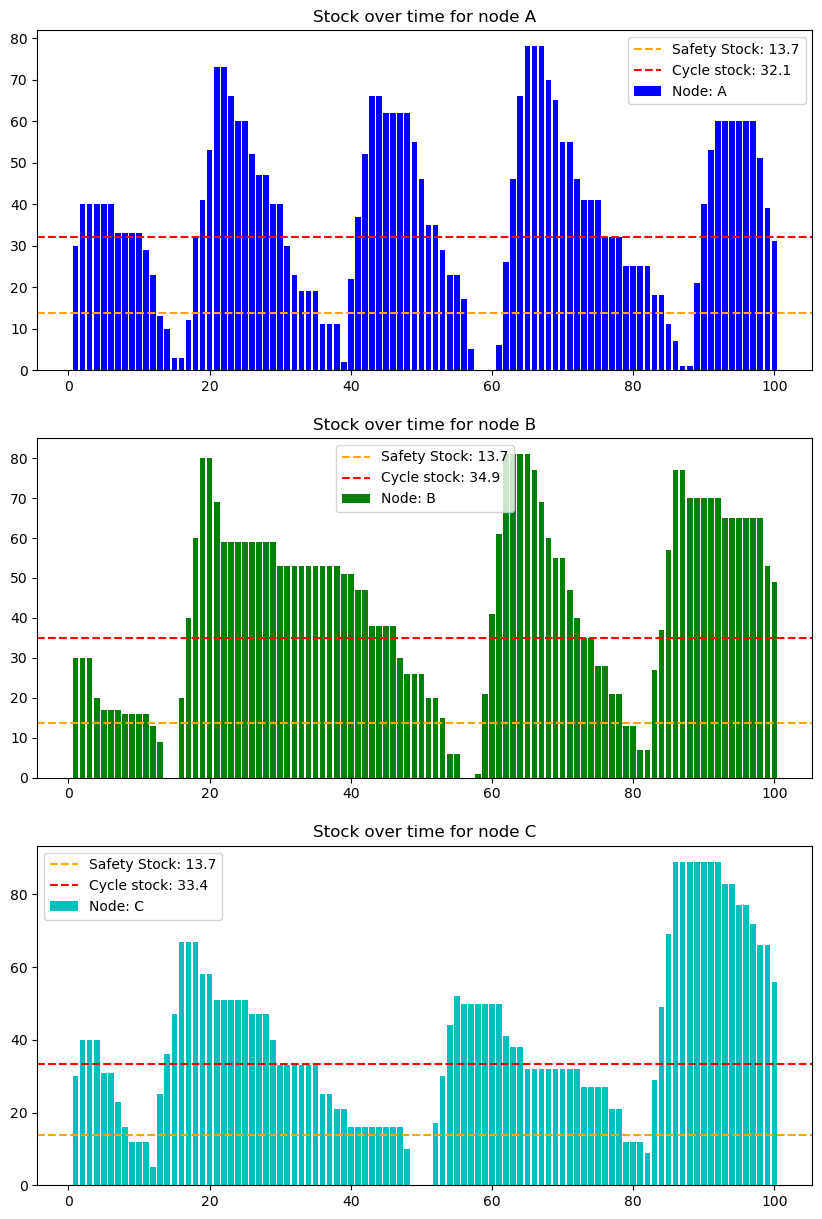

In [8]:
plot_safety_stock(df, safety_stock = safety_stock)